# 1. Introduction
[NASA HI-SEAS](https://hi-seas.org/) missions act as a testbed and training ground for humans as we develop the capability to explore Mars. 
A recent NASA Space Apps Challenge hackathon asked participants to use data collected from the HI-SEAS site to predict solar radiation given a set of measurable meteorological conditions.
Knowing when conditions are most favorable for incident solar radiation is crucial for deciding when and where to deploy solar energy harvesting equipment, especially for colonists or astronauts on the surface of Mars.

The original Kaggle dataset & competition can be found here: https://www.kaggle.com/dronio/SolarEnergy

## 1.1. Scenario
We are participants in a NASA HI-SEAS (Hawai’i Space Exploration Analog and Simulation) mission, simulating a human settlement on Mars. 

A large solar array and battery bank are installed at the settlement and are the only power source available.
On sunny days, the array collects enough energy to power the entire settlement and recharge the battery bank.
The battery bank is used (sparingly) at night and on overcast days.
There is a strict power budget for operations each day to make sure vital equipment stays online, and we also have a number of experiments to run.

We have been collecting data at our settlement since the end of the last HI-SEAS mission in September, 2016.
It is now January, 2017, and our mission is about to begin.

Given weather measurements taken before sunrise, can we predict how much radiation will be harvested until sunset? 

## 1.2. About this dataset
These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) is useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in `yyyy-mm-dd` format The local time of day in `hh:mm:ss` 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:

* Solar radiation: watts per meter^2
* Temperature: degrees Fahrenheit
* Humidity: percent
* Barometric pressure: Hg
* Wind direction: degrees
* Wind speed: miles per hour
* Sunrise/sunset: Hawaii time

## 1.3. About this kernel
The purpose of this kernel is to explore this dataset and apply basic machine learning techniques in order to predict optimal conditions for maximal radiation.

This is my first foray into the world of data science and machine learning (ML). 
As such, it is expected that the following code will not be optimized for memory, runtime, or readability.
However, the result is still expected to be at worst interesting, at most useful.

I have decided to use Python 3 since it is widely used for data science, a versatile and useful language (even outside of data processing and ML), and a new language to me -- I'd like the practice.

## 1.4. Thanks
I would like to thank the following groups and individuals for providing the tutorials, resources, and inspiration to conduct this study.
* [NASA & Kaggle](https://www.kaggle.com/dronio/SolarEnergy), for providing this dataset.
* [sentdex on YouTube](https://www.youtube.com/playlist?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v), for his incredible series on machine learning and everything else Python.
* Sarah Linden, for encouraging me to do engineering projects in my free time.

# 2. Preprocessing the data
Before applying any machine learning techniques, the input data must be ingested and conditioned.

First, all of the data is loaded in as the appropriate data types.
The column `Data` contains a single, unchanging timestamp. This appears to be the dat the dataset was published, but that is unclear.
For our purposes, this is not useful information and the column is removed from the dataset.

All units are converted into their SI counterparts (if they are not already in SI units).
Time of day, sunrise, and sunset values are converted to UNIX time (we can always translate it back later).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # processing dates and times

In [12]:
# ingest data
data=pd.read_csv('input/SolarPrediction.csv') # import csv as pandas DataFrame

# Data column is unused
data.drop(['Data'], axis = 1, inplace = True)

# interpret columns as appropriate data types
data['UNIXTime'] = data['UNIXTime'].astype(str)
data['Time'] = data['Time'].astype(str)
data['Radiation'] = data['Radiation'].astype(float)
data['Temperature'] = data['Temperature'].astype(float) # or int
data['Pressure'] = data['Pressure'].astype(float)
data['Humidity'] = data['Humidity'].astype(int) # or int
data['WindDirection(Degrees)'] = data['WindDirection(Degrees)'].astype(float)
data['Speed'] = data['Speed'].astype(float)
data['TimeSunRise'] = data['TimeSunRise'].astype(str)
data['TimeSunSet'] = data['TimeSunSet'].astype(str)

# convert units to SI
data.loc[:,'Temperature'] = (data.loc[:,'Temperature'] + 459.67)*5.0/9.0 # degrees F --> Kelvin
data.loc[:,'Pressure'] *= 3386.0 # inches Hg --> Pascal
data.loc[:,'WindDirection(Degrees)'] = np.deg2rad(data.loc[:,'WindDirection(Degrees)']) # degrees --> radians
data.loc[:,'Speed'] *= 0.447 # MPH --> m/s
data.rename(columns={'UNIXTime':'Date','Time':'Time of Day','WindDirection(Degrees)':'Wind Direction','Speed':'Wind Speed'}, inplace=True)

# rename columns to avoid ambiguities
data.rename(columns={'Speed': 'WindSpeed', 'WindDirection(Degrees)': 'WindDirection'}, inplace=True)

# convert times to datetime objects
data['Date'] = pd.to_datetime(data['Date'],unit='s').dt.date
data['Time of Day'] = pd.to_datetime(data['Time of Day'],format='%H:%M:%S').dt.time
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise'],format='%H:%M:%S')
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet'],format='%H:%M:%S')

# create a dictionary of unit labels
unitLabels={'Time of Day':'HST','Radiation':'W/m^2','Temperature':'K', \
            'Pressure':'Pa','Humidity':'\%','Wind Direction':'rad', \
            'Wind Speed':'m/s','TimeSunRise':'HST','TimeSunSet':'HST'}

Note that `TimeSunRise` and `TimeSunSet` include an arbitrary date value attached to them. 
The arbitrary date can be easily removed for display in the future by converting these values to `datetime.time` objects, but for now it is easiest to leave them as `datetime` objects so we can perform operations on them later.

## 2.1. Exploring the Data
Machine learning algorithms operate on _features_ to predict _labels_.

* A __feature__ is an attribute of the system that affects the output. 
Features act as "inputs" to the model.
Ideally, features are _independent_ variables.
* A __label__ is the value being predicted. 
Labels act as "outputs" of the model.

Now, let's consider our scenario. 
Which data should we consider to be _features_?

From the source, we make a few initial plots to see if we can find any obvious relationships.
I am a visual thinker, so this step is only to provide perspective on what information lies within the data.

In [3]:
# Import plotting libraries
import matplotlib.pyplot as plt # plotting tools

# make IPython render plots inline
%matplotlib inline 

### 2.1.1. Radiation vs. Date
First, let's explore how radiation varies with time.

There are two timescales to consider here:
* Day of the year
* Time of day

Radiation may vary with the date due to seasons or changes in solar radiation emitted from the sun.
The intensity of solar radiation is correlated to the number of sun spots observed, which follows an 11-year cycle [\[1\]](https://en.wikipedia.org/wiki/Solar_cycle).

Additionally, the duration in which a location is illuminated by solar radiation changes over the course of the year due to Earth's seasons.
During shorter days, there is less time to harvest solar energy. 
Thus we must compute the duration of the day as the time between sunrise and sunset in seconds. 
This information seems like it'll be useful for the future as well, so we'll add it as a column in our `data` DataFrame.

In [4]:
# find length of each day
data['Length of Day'] = (data['TimeSunSet']-data['TimeSunRise'])/np.timedelta64(1, 's')
unitLabels['Length of Day']='s'

Some days have more than one unique sunrise or sunset time reported.
Since it cannot be true that for a given date the sun rose at `06:24:00` and also rose at `06:25:00`, we must assume that the source data has some error.

At most these durations vary by one minute, so the error incurred is minimal when performing analysis on the day scale.
We can leave these rows intact since they are not out of tolerance enough to be considered outliers, but we know that they will introduce some noise into this analysis.

Since we desire to maximize solar radiation for a given day, it is best to be conservative and assume the shorter length of day to be correct.

To make analysis a bit more concise, we'll group the data by date.
To preserve the integrity of our original data (and make sure we don't screw anything up) we'll store this as a new object.

In [5]:
# group data by day of the year
data_bydate=data.groupby('Date')

First, we check to see how radiation changes over long periods of time.
And, to remove the potential impact of different day lengths, we normalize radiation by length of the day.

Also, since we're operating on elements of a group, our resultant `normalized_rad_per_day` value is indexed by `Date`, just like the rest of the group.

(<matplotlib.axes._subplots.AxesSubplot at 0x1b3d1ce8390>,
 <matplotlib.text.Text at 0x1b3d1a614a8>)

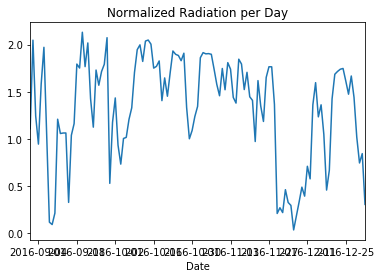

In [6]:
normalized_rad_per_day=data_bydate['Radiation'].sum()/data_bydate['Length of Day'].min()
normalized_rad_per_day.plot(), plt.title('Normalized Radiation per Day')

Looks like there are more significant variables at play here...

Let's overlay the plot of `Normalized Radiation per Day` with the mean temperature and humidity for each day.
We only care about _relative_ values at the moment, so we'll normalize those too.

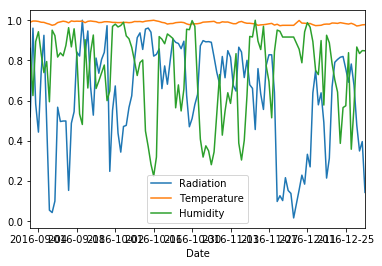

In [7]:
# replot normalized radiation
normalized_rad_per_day=normalized_rad_per_day/normalized_rad_per_day.max() # normalize to 0-->1
normalized_rad_per_day.plot(label='Radiation')

# compute normalized mean temperature
mean_temp_per_day=data_bydate['Temperature'].mean()
normalized_mean_temp_per_day=mean_temp_per_day/mean_temp_per_day.max()
normalized_mean_temp_per_day.plot()

# compute normalized mean humidity
mean_humidity_per_day=data_bydate['Humidity'].mean()
normalized_mean_humidity_per_day=mean_humidity_per_day/mean_humidity_per_day.max()
normalized_mean_humidity_per_day.plot()

plt.legend()

It is apparent that temperature has a significant impact on solar radiation observed.

Changes in humidity are very small compared to temperature and radiation, but could still have an impact. 
And we haven't even plotted pressure yet...

One last check before we let machine learning do its magic and tie these variables together.

### 2.1.2. Radiation vs. Time of Day
In `pandas`, grouped sets are harder to deal with than plain old DataFrames. 
We can do all the same grouping without explicitly grouping the data as well.

So, let's plot `Radiation` over `Time of Day` and give every day of the year a different color.
We expect the result to show that peak radiation occurs around high noon.

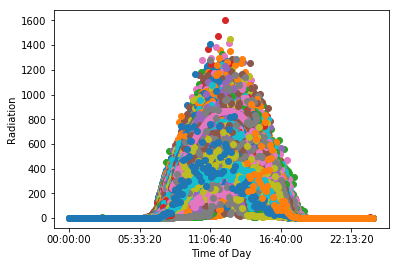

In [8]:
# plot radiation for time of day on same plot
fig, ax = plt.subplots()
for date, group in data_bydate:
    ax.plot(group['Time of Day'], group['Radiation'], marker='.', linestyle='', ms=12, label=date)
# ax.legend() # too many dates to show
plt.ylabel('Radiation')
plt.xlabel('Time of Day')
plt.show()

And peak radiation occurs around noon as expected.
It might be easier to show this plot with dates grouped by month, but we have more important things to do!

### 2.1.3. Other Visualizations
Lastly, lets see if we can find other (perhaps unexpected) relationships in the data.

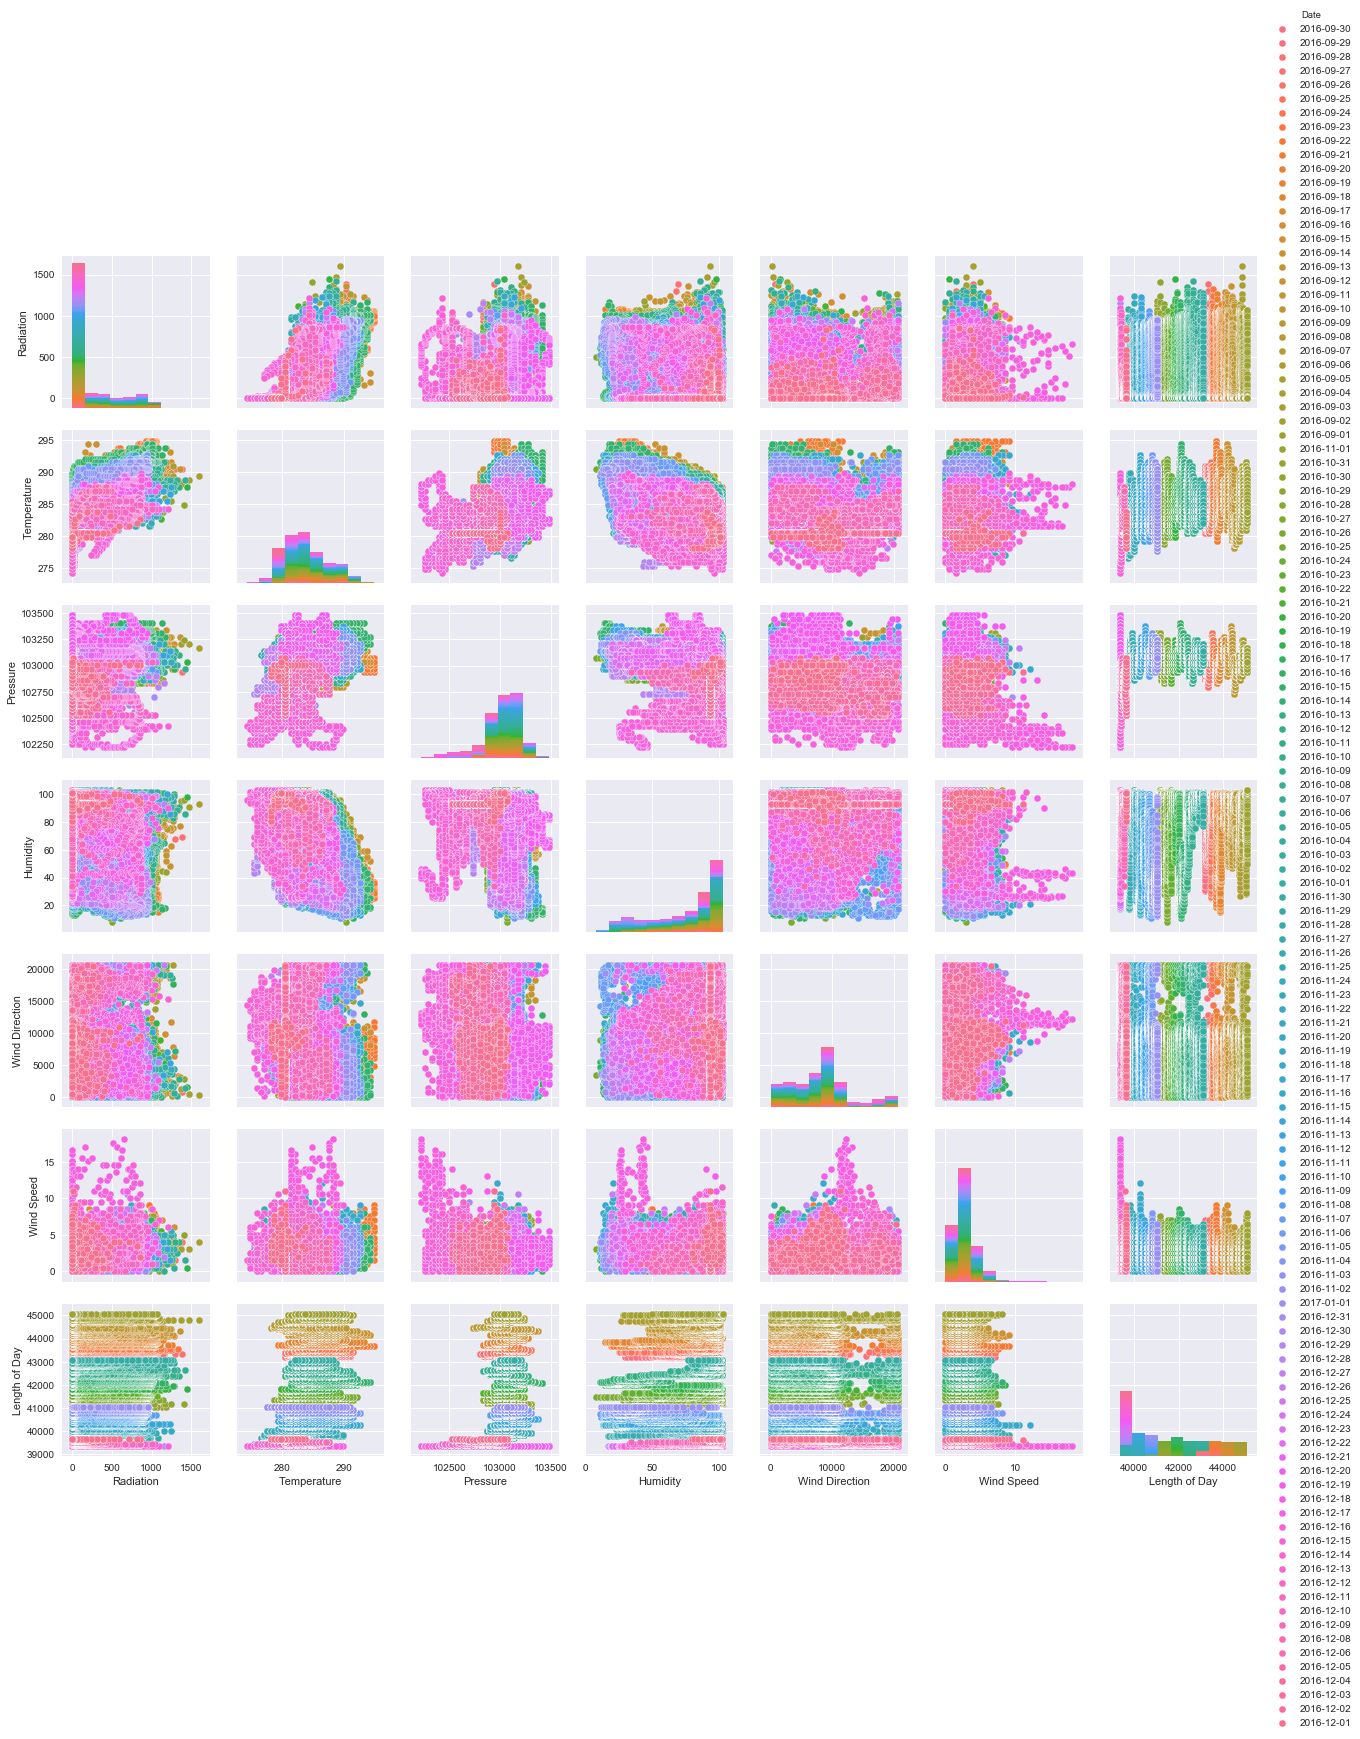

In [9]:
import seaborn as sns # advanced statistics plotting tools

sns.pairplot(data,hue='Date')
plt.show()

D:\Programs\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


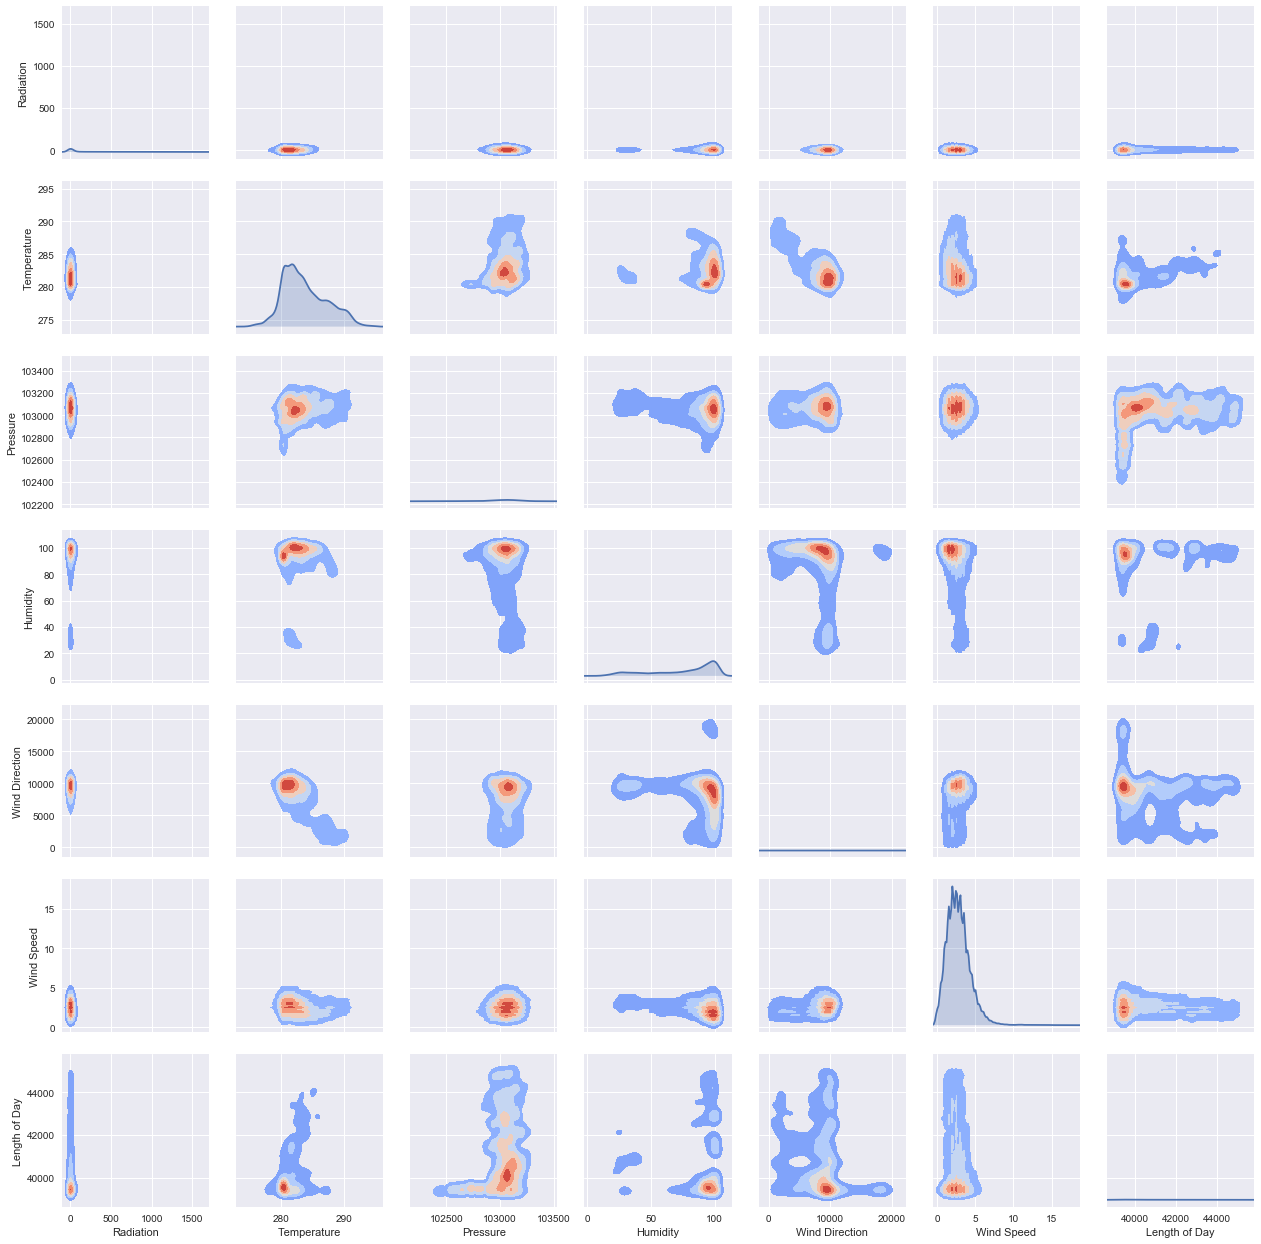

In [10]:
g=sns.PairGrid(data);
g.map_diag(sns.kdeplot, shade=True)
g.map_offdiag(sns.kdeplot, shade=True, shade_lowest=False, cmap='coolwarm', n_levels=6);
plt.show()

## 2.2. Preparing the Prediction Algorithm
We desire an algorithm that will predict values (radiation for a given set of inputs), we have plenty of data to train with, and we have "unlimited" time. Thus, we select a __regression__ model.
There are many regression models to choose from like Linear Regression and Neural Networks, and there may be more than one that is appropriate.

Even before we downselect to a specific model, we can prepare a prediction algorithm that takes in our data and makes a prediction.
Using [`scikit learn`](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning), it is easy to swap out different models and maintain the same higher-level structure to the program.